<a href="https://colab.research.google.com/github/karlyjerman/IMFS-Summer-Kaggle/blob/master/Copy_of_PyTorch_Tutorial_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch - ODSC West 2018

## Robert Alvarez - Senior Data Scientist at Metis


![](http://community.datacamp.com.s3.amazonaws.com/community/production/ckeditor_assets/pictures/248/content_odsc.png)

![](https://devblogs.nvidia.com/wp-content/uploads/2017/04/pytorch-logo-dark.png)

# Installing PyTorch (on Google Server)

Go to https://colab.research.google.com and sign in with your Google account. If you do not have a Google account you can create one. From there you can create a new notebook.

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install --no-cache-dir -I pillow
!pip install unidecode

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 2.0MB 9.3MB/s 


In [2]:
# usual suspects
import os
import time
import shutil
import requests
import zipfile
from PIL import Image

import numpy as np
import pandas as pd
from cycler import cycler

# the good stuff
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

# standard sklearn import
from sklearn.metrics import accuracy_score

# minor changes to plotting functions
import matplotlib.pyplot as plt
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c


%matplotlib inline

# change margin size of jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [0]:
# Download all necessary files for the live tutorial
# Post ODSC pull from GitHub Repo github.com/robert-alvarez

data_url = 'https://www.dropbox.com/s/dbb0sf9d3r6rymo/odsc_pytorch_data_with_model.zip?dl=1'

if not os.path.exists('data'):
    # Download the data zip file.
    response = requests.get(data_url, stream=True)
    zip_path = 'odsc_pytorch_data.zip'
    with open(zip_path, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    # Unzip the file.
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall()
    # Move files.
    shutil.move('odsc_pytorch_data/data', 'data')
    shutil.move('odsc_pytorch_data/fashionmnist', 'fashionmnist')
    # Clean up.
    shutil.rmtree('__MACOSX')
    shutil.rmtree(zip_path[:-4])
    os.remove(zip_path)

In [4]:
!ls

data  fashionmnist  sample_data


# PyTorch

What is PyTorch?

* It is a replacement for NumPy to use GPUs
* A deep learning platform built for flexibility and speed


## Tensor Overview
What are tensors?

Tensors are similar to NumPy's `ndarrays`

We normally think of tensors as a generalization of matrices. In fact, matrices are 2-D tensors!

![](https://image.slidesharecdn.com/tensordecomposition-170301235239/95/a-brief-survey-of-tensors-5-638.jpg?cb=1488412458)

Here is a great visualization of tensors from 1-D to 5-D

![](https://cdn-images-1.medium.com/max/2000/1*_D5ZvufDS38WkhK9rK32hQ.jpeg)

As mentioned before, since tensors are generalizations of matrices, we should be able to create them in similar ways. We can also expect *most* operations to stay the same. In particular, addition of tensors is the same as for matrices. Multiplication is a bit different, but we won't have to concern ourselves with that in this lecture.

### Tensor Types

Torch defines eight CPU tensor types and eight GPU tensor types:

| Data type                | dtype                             | CPU Tensor           | GPU Tensor                |
|--------------------------|-----------------------------------|----------------------|---------------------------|
| 32-bit floating point    | `torch.float32` or `torch.float`  | `torch.FloatTensor`  | `torch.cuda.FloatTensor`  |
| 64-bit floating point    | `torch.float64` or `torch.double` | `torch.DoubleTensor` | `torch.cuda.DoubleTensor` |
| 16-bit floating point    | `torch.float16` or `torch.half`   | `torch.HalfTensor`   | `torch.cuda.HalfTensor`   |
| 8-bit integer (unsigned) | `torch.uint8`                     | `torch.ByteTensor`   | `torch.cuda.ByteTensor`   |
| 8-bit integer (signed)   | `torch.int8`                      | `torch.CharTensor`   | `torch.cuda.CharTensor`   |
| 16-bit integer (signed)  | `torch.int16` or `torch.short`    | `torch.ShortTensor`  | `torch.cuda.ShortTensor`  |
| 32-bit integer (signed)  | `torch.int32` or `torch.int`      | `torch.IntTensor`    | `torch.cuda.IntTensor`    |
| 64-bit integer (signed)  | `torch.int64` or `torch.long`     | `torch.LongTensor`   | `torch.cuda.LongTensor`   |

**Note**: Tensor types need to match when doing calculations with them.

### Numpy ndarrays vs PyTorch Tensors

Let's look at the differences between these two common methods of handling arrays. 

In [5]:
# In numpy, we create tensors (arrays) in the following way
x1 = np.random.rand(5,3)
print(f"x1 =\n {x1}\n")

# Similar to numpy we can create random tensors
t1 = torch.rand(5,3, dtype=torch.float64)
print(f"t1 =\n {t1}")

x1 =
 [[0.20364877 0.74298409 0.96700002]
 [0.84528057 0.39095302 0.66858728]
 [0.50898456 0.81269528 0.6155952 ]
 [0.33497482 0.10682906 0.14098398]
 [0.95293779 0.12515395 0.19397763]]

t1 =
 tensor([[0.7990, 0.5257, 0.1455],
        [0.1549, 0.0290, 0.3978],
        [0.6007, 0.9926, 0.3806],
        [0.0231, 0.9590, 0.3822],
        [0.3584, 0.7487, 0.6091]], dtype=torch.float64)


In [6]:
# check the type
print(f"t1 is a {type(t1)}")
print(f"x1 is a {type(x1)}")

t1 is a <class 'torch.Tensor'>
x1 is a <class 'numpy.ndarray'>


In [7]:
print(f"t1 is dtype {t1.dtype}")
print(f"x1 is dtype {x1.dtype}")

t1 is dtype torch.float64
x1 is dtype float64


In [8]:
# create a 3-D tensor in torch and numpy
t2 = torch.rand(2, 3, 5) # first is how many arrays I want and the later two fields are the size
print(f"t2 =\n {t2}\n")

x2 = np.random.rand(2, 3, 5)
print(f"x2 =\n {x2}")

t2 =
 tensor([[[0.5643, 0.8569, 0.5403, 0.7119, 0.2329],
         [0.6588, 0.6509, 0.8727, 0.7104, 0.4615],
         [0.0208, 0.6308, 0.8416, 0.5067, 0.2553]],

        [[0.6024, 0.0456, 0.2746, 0.3965, 0.0722],
         [0.4155, 0.7892, 0.9030, 0.4756, 0.4386],
         [0.5042, 0.4689, 0.9820, 0.6350, 0.4463]]])

x2 =
 [[[0.88584817 0.37365921 0.51414374 0.20426782 0.23526041]
  [0.07554486 0.52388662 0.78275957 0.04928737 0.0581099 ]
  [0.84049242 0.03901867 0.57177618 0.83676623 0.29196086]]

 [[0.28516281 0.20003764 0.64158124 0.53325965 0.57992001]
  [0.70564992 0.78590104 0.64169111 0.83782777 0.650275  ]
  [0.27338939 0.05394239 0.20069068 0.36285395 0.45605154]]]


In [9]:
long_tensor = torch.zeros(5,3, dtype=torch.long)
print(long_tensor)
print(long_tensor.dtype)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
torch.int64


In [10]:
float_tensor = torch.zeros(5,3, dtype=torch.float64)
print(float_tensor)
print(float_tensor.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
torch.float64


In [11]:
long_tensor + float_tensor

RuntimeError: ignored

In [12]:
float_tensor + long_tensor

RuntimeError: ignored

In [13]:
# we can also create explicit tensors
x = torch.tensor([2., 3])
x

tensor([2., 3.])

In [14]:
# this method creates a new tensor "y" that has the same properties (e.g. dtype) as the original tensor "x"
y = x.new_ones(5,3)
print(y)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [15]:
# there's a size method as well
y.size()

torch.Size([5, 3])

In [16]:
# We can add tensors as well in the usual way you expect
x = torch.rand(5,3)
x + y

tensor([[1.9959, 1.4949, 1.2392],
        [1.7235, 1.9920, 1.8305],
        [1.9973, 1.5868, 1.4598],
        [1.7328, 1.4975, 1.6981],
        [1.1270, 1.6100, 1.9639]])

In [17]:
# We can also add like this
torch.add(x, y)

tensor([[1.9959, 1.4949, 1.2392],
        [1.7235, 1.9920, 1.8305],
        [1.9973, 1.5868, 1.4598],
        [1.7328, 1.4975, 1.6981],
        [1.1270, 1.6100, 1.9639]])

In [18]:
# OR like this!
# The `*_` method works just like `inplace=True` in pandas
y.add_(x)  # the underscore method overwrites the value of y and adds x. without the underscore just does a normal add

tensor([[1.9959, 1.4949, 1.2392],
        [1.7235, 1.9920, 1.8305],
        [1.9973, 1.5868, 1.4598],
        [1.7328, 1.4975, 1.6981],
        [1.1270, 1.6100, 1.9639]])

In [19]:
# see!
y

tensor([[1.9959, 1.4949, 1.2392],
        [1.7235, 1.9920, 1.8305],
        [1.9973, 1.5868, 1.4598],
        [1.7328, 1.4975, 1.6981],
        [1.1270, 1.6100, 1.9639]])

In [20]:
# Indexing works just like in numpy
y[:, 1]

tensor([1.4949, 1.9920, 1.5868, 1.4975, 1.6100])

In [21]:
# We can reshape tensors as well though it's called "view" in pytorch
x = torch.randn(4,4)
y = x.view(16)
z = x.view(-1, 8)
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


More on torch operations can be found here: https://pytorch.org/docs/stable/torch.html#math-operations

In [22]:
# Converting to/from PyTorch & NumPy is easy
a = torch.ones(5)
a

tensor([1., 1., 1., 1., 1.])

In [23]:
# convert to numpy
b = a.numpy()
b

array([1., 1., 1., 1., 1.], dtype=float32)

In [24]:
# what do we expect this result to be?
a.add_(1)
print(a)
print(b)

# b is a pointer to a. this is why when you change a, b changes as well. you could make a copy instead if you do not want it to be a pointer

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


In [25]:
# Convert from numpy to torch
c = np.random.randn(4,5)
print(c)
d = torch.from_numpy(c)
print(d)

[[-1.43144133  1.55953245  0.62511162 -0.46640178 -1.87977682]
 [-0.69288368 -1.10079421  0.23108826 -1.09012441  0.21208954]
 [ 0.23504262  0.96351817  0.20331469  0.27989765 -0.29854953]
 [-0.57389858  0.59574427 -1.04865745 -0.48830288  0.3618687 ]]
tensor([[-1.4314,  1.5595,  0.6251, -0.4664, -1.8798],
        [-0.6929, -1.1008,  0.2311, -1.0901,  0.2121],
        [ 0.2350,  0.9635,  0.2033,  0.2799, -0.2985],
        [-0.5739,  0.5957, -1.0487, -0.4883,  0.3619]], dtype=torch.float64)


## Autograd - AKA why PyTorch is awesome

Central to all Neural Networks in PyTorch is the `autograd` package. 

The `autograd` package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, 
which means that your backprop is defined by how your code is run, and that every single iteration can be different.

Let's look at a basic example of this before returning to our Neural Networks again.

In [26]:
# Create a tensor and set requires_grade=True to track computation with it
x = torch.ones(2,2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [27]:
# Do some operation on said tensor
y = 3*x + 7
print(y)

tensor([[10., 10.],
        [10., 10.]], grad_fn=<AddBackward>)


In [28]:
# Because y was created as a result of an operation, it now has a grad_fn method
y.grad_fn

In [29]:
# We can do more stuff to y (and thus x) and calculate its derivatives
z = 2*y**2
w = z.mean()

print(z, w)

tensor([[200., 200.],
        [200., 200.]], grad_fn=<MulBackward>) tensor(200., grad_fn=<MeanBackward1>)


In [0]:
# Backpropagation in one line!
w.backward() # calculates the gradient 

In [31]:
# et voila!
x.grad # the gradient for x

tensor([[30., 30.],
        [30., 30.]])

## Linear Regression Example

One of the classic problems in machine leaarning is trying to find the line of best fit for some given data.

In [0]:
n=200

In [33]:
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[ 0.5448,  1.0000],
        [-0.4639,  1.0000],
        [-0.8946,  1.0000],
        [ 0.2832,  1.0000],
        [ 0.6275,  1.0000]])

In [34]:
a = torch.tensor([5.,3]) 
a

tensor([5., 3.])

In [0]:
y = x@a + torch.rand(n) # this winds up being just 5x + 3 when you multiply the matrix

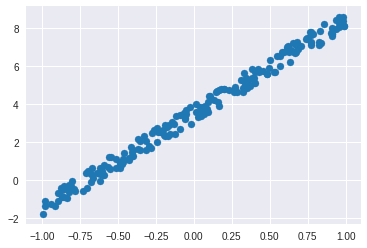

In [36]:
plt.scatter(x[:,0], y);

In [0]:
# define the loss function we will be minizing
def mse(y, y_pred): 
    return ((y - y_pred)**2).mean()

In [0]:
# start with some initial guess 
a_guess = torch.tensor([-1.,1])

In [39]:
# find the "best" line given this guess
# and determine the loss 
y_pred = x@a_guess
mse(y, y_pred)

tensor(19.4048)

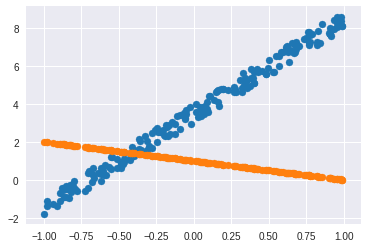

In [40]:
# see how the answer differs from the original
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_pred);

In [41]:
a_guess = nn.Parameter(a_guess)
a_guess

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [0]:
def update():
    '''
    function to update tensor using SGD
    '''
    y_pred = x@a_guess # x times the guess I have at the current step
    loss = mse(y, y_pred) # the mean squared error
    
    if t % 10 == 0: 
        print(loss)
        
    loss.backward()
    with torch.no_grad():
        a_guess.sub_(lr * a_guess.grad) # take my random guess, subtract from a the learning rate times the gradient (gradient descent)
        a_guess.grad.zero_() # zero out the gradient so that you can start from scratch next time

In [43]:
lr = 1e-1
for t in range(100): 
    update()

tensor(19.4048, grad_fn=<MeanBackward1>)
tensor(3.0500, grad_fn=<MeanBackward1>)
tensor(0.8277, grad_fn=<MeanBackward1>)
tensor(0.2779, grad_fn=<MeanBackward1>)
tensor(0.1366, grad_fn=<MeanBackward1>)
tensor(0.1001, grad_fn=<MeanBackward1>)
tensor(0.0908, grad_fn=<MeanBackward1>)
tensor(0.0883, grad_fn=<MeanBackward1>)
tensor(0.0877, grad_fn=<MeanBackward1>)
tensor(0.0876, grad_fn=<MeanBackward1>)


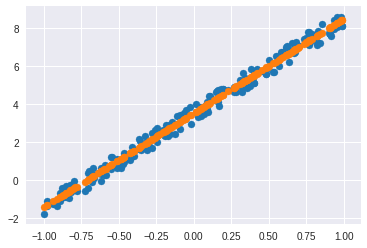

In [44]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], x@a_guess.detach());

### Normal Equations
Although we solved for the line of best fit using stochastic gradient descent,
we could have also used the [Normal Equations](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations) given by

$$ \theta = (X^T X)^{-1} X^T \vec y$$

where $\theta$ is the vector we called `a_guess`

In [50]:
# Exercise:
# Use pytorch to solve for theta using the normal equations
# plot your result when you are finished

# Code goes here

#torch.t(x) gives you the transpose
#x.inverse() gives you the inverse


theta = ((torch.t(x) @ x)).inverse() @ torch.t(x) @ y
theta

tensor([4.9795, 3.5263])

# Neural Nets

Neural networks (NNs) are special forms of nonlinear regressions where the decision system for which the NN is built mimics the way 
the brain is supposed to work (whether it works like a NN is up for grabs of course).

Like many of the algorithms we have seen before, it is a supervised learning technique that can perform complex tasks.

## Perceptrons

The basic building block of a neural network is a perceptron. A perceptron is like a neuron in a human brain. It takes inputs 
(e.g. sensory in a real brain) and then produces an output signal. An entire network of perceptrons is called a neural net.

![linear regression](https://cdn.pbrd.co/images/Hs1n4DL.png)

In general, a perceptron could have more or fewer inputs.

Instead of assigning equal weight to each of the inputs, we can assign real numbers $w_1, w_2, \ldots$ expressing the importance of the respective inputs to the output. The nueron's output, 0 or 1, is determined whether the weighted sum $\sum_j w_j x_j$ is less than or greater than some *threshold value*.

Perceptrons may emit continuous signals or binary $(0,1)$ signals. In the case of a credit card application, the final perceptron is a binary one (approved or denied). Such perceptrons are implemented by means of squashing functions. For example, a really simple squashing function is one that issues a 1 if the function value is positive and a $-1$ if it is negative.

To put this in more mathematical terms, let $z = \sum_{j=0}^n w_j x_j$ . 
Then the *activation function* $\phi(z)$ is defined as 

$$
\phi(z) =
\begin{cases}
-1 & \text{if } z < \theta\\
 1 & \text{if } z \geq \theta
\end{cases}
$$

![](https://github.com/robert-alvarez/pytorch_tutorial/blob/master/img/activation-function.png?raw=1)

The whole point of the perceptron is to mimic how a single nueron in the brain works: it either *fires* or it doesn't. Thus, the 
perceptron rule is fairly simple and can be summarized by the following steps.
​
* Initialize the weights to zero or small random numbers
* For each training sample $\textbf{x}_n$ perform the following steps:
    * Compute the output value $y$
    * Calculate error in $y$ vs $\hat y$
    * Update the weights
  
Here, the output value is the class label predicted by the activation function that we defined earlier, and the
simultaneous update of weight $w_j$ in the weight vector $\textbf{w}$ can be more formally written as
​
$$\bar w_j = w_j + \Delta w_j$$


## Fitting a model

Let's go back to our linear perceptron. It has the following parameters:

* $x_i$: inputs
* $y$ : output
* $w_i$: learned weights

What we would like to do is adjust the $w_i$'s until our model has the best fit.

First, initialize the $w_i$'s in some meaningful way (usually they're drawn from a randon uniform distribution).

Then, we put it into our usual **algorithm workflow:**

* calculate prediction $\hat y$
* calculate Loss function $L(y, \hat y)$
* update weights using backpropagation

### Loss function and backpropagation

To figure out how well our prediction was during each epoch, we'll use a basic loss function, mean squared error (MSE):

$L(y,\hat{y}) = ||~ y-\hat{y} ~||^2$,

ultimately trying to find $L_{\rm min}$, defined by the point in parameter space where $\nabla_{w_i} L = 0$.

Per-iteration update: 

$ w_i \to w_i - \eta \nabla_{w_i} L $,

where $\eta$ is known as the learning rate; too small and takes very long to converge, too big and you oscillate about the minimum.


## A basic example
​
We'll build an overly complex adding machine that will illustrate how neural nets work.

In [51]:
model = nn.Sequential(
            nn.Linear(2, 1, bias=False)) #input, output - take in two and return 1

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=False)
)


In [52]:
total_loss = [] # we want to track the loss
num_samples = 10000 # give it 10000 samples

for num in range(num_samples):
    # Progress bar indicator
    if num % (num_samples//5) == 0:
        print('{0}: %: {1:.3f}'.format(num,num/num_samples * 100))
        
    # data prep
    x = 4*torch.rand(2) #generate two random numbers uniformly on (0,4)
    data, target = Variable(x), Variable(x[0] + x[1])
    
    # Feed forward through NN
    output = model(data)
    loss = criterion(output, target)
    total_loss.append(loss)
    
    # Backpropagation
    optimizer.zero_grad() # take in the optimizer and zero out the gradient
    loss.backward() # gradient descent
    optimizer.step() # step through the optimizer

0: %: 0.000
2000: %: 20.000
4000: %: 40.000
6000: %: 60.000
8000: %: 80.000


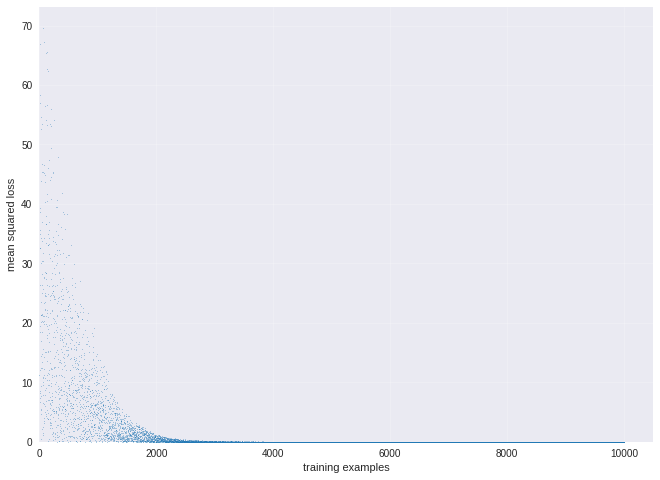

In [53]:
# plot errors
fig,ax=plt.subplots(figsize=(11,8))
ax.plot(total_loss,marker='.',ls='',markersize=1.)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

In [0]:
# plot results
x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(11,8))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'Where we have \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);


## Feedforward Neural Network

![General Feed Forward Network](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-1.44.58-PM.png)

For our case of learning linear relationships, the modification to the linear regression architecture is depicted below:


![non-linear activation](https://cdn.pbrd.co/images/Hs3GrKM.png)

where

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

is the so-called sigmoid function; this is typically the activation function that is first introduced, I think because of historical reasons. In modern practice, it finds most of its use in transforming single outputs from a NN into a probability. It's worth noting that if your NN will output multiple probabilities, for example, if your NN will categorize between black cats, red cats, white cats, etc., a multi-dimensional generalization of the sigmoid, called the softmax function, is typically used. 

The motivation behind adding an activation function is the hope that the NN model may capture non-linear relationships that exist in the data. Below are some commonly used activation functions. 

![activation functions](https://cdn-images-1.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

In practice, a lot of architectures use the rectified linear unit (ReLU), along with it's close cousin, the so-called leaky-ReLU. In introducing this idea though, let's focus on the sigmoid which maps real numbers from $(-\infty,\infty) \to [0,1]$.

Of course our data is linear in the case of a straight line (!) but let's see what happens if we try to force a non-linear activation layer to capture a linear relationship..

## Non-linear model for a linear relationship

### Deep Feedforward Network with sigmoid activation

In [55]:
model = nn.Sequential( # layers within a neural net
            nn.Linear(2, 20), # give me the linear node. I'll put in 2 and give me 20 out
            nn.Sigmoid(), # squash it to the sigmoid
            nn.Linear(20, 20), # put in 20 and return 20
            nn.Sigmoid(), # squash it to the sigmoid
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1))

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=20, out_features=1, bias=True)
)


In [56]:
total_loss = []
num_samples = 10000

for num in range(num_samples):
    # Progress bar indicator
    if num % (num_samples//5) == 0:
        print('{0}: %: {1:.3f}'.format(num,num/num_samples * 100))
        
    # data prep
    x = 4*torch.rand(2) #generate two random numbers uniformly on (0,4)
    data, target = Variable(x), Variable(x[0] + x[1])
    
    # Feed forward through NN
    output = model(data)
    loss = criterion(output, target)
    total_loss.append(loss)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: %: 0.000
2000: %: 20.000
4000: %: 40.000
6000: %: 60.000
8000: %: 80.000


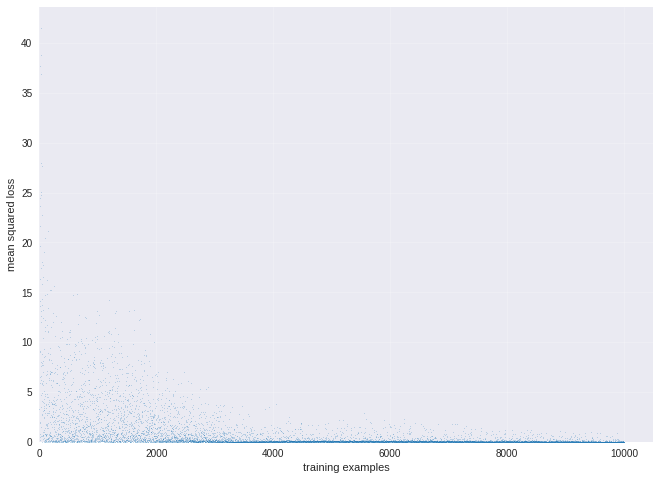

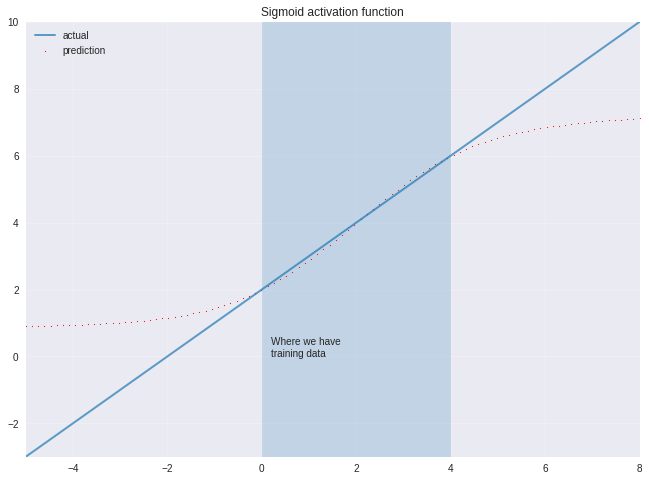

In [57]:
fig,ax=plt.subplots(figsize=(11,8))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(11,8))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'Where we have \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
ax.set_title('Sigmoid activation function');

## Try your own activation functions!

In [74]:
# Build your own adding machine using any of the 
# activation functions given above. Do any of them
# perform worse than others?
# See here for more functions

#https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity


model = nn.Sequential(
            nn.Linear(2, 20), 
            nn.ReLU(), 
            nn.Linear(20, 20), 
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1)
            )

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=20, out_features=1, bias=True)
)


In [75]:
# check your loss scores

total_loss = []
num_samples = 10000

for num in range(num_samples):
    # Progress bar indicator
    if num % (num_samples//5) == 0:
        print('{0}: %: {1:.3f}'.format(num,num/num_samples * 100))
        
    # data prep
    x = 4*torch.rand(2) #generate two random numbers uniformly on (0,4)
    data, target = Variable(x), Variable(x[0] + x[1])
    
    # Feed forward through NN
    output = model(data)
    loss = criterion(output, target)
    total_loss.append(loss)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: %: 0.000
2000: %: 20.000
4000: %: 40.000
6000: %: 60.000
8000: %: 80.000


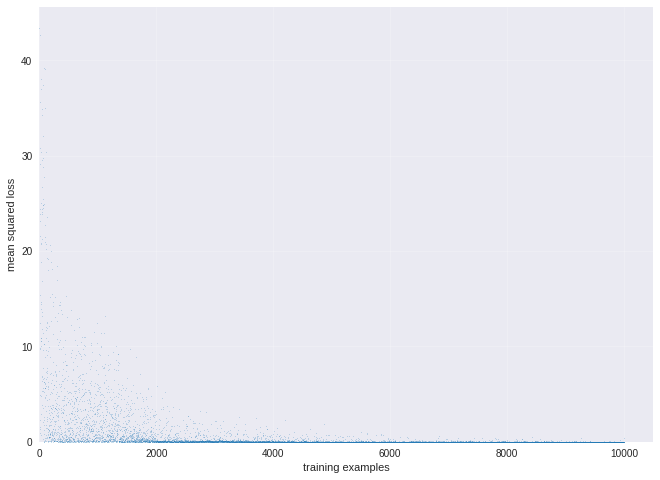

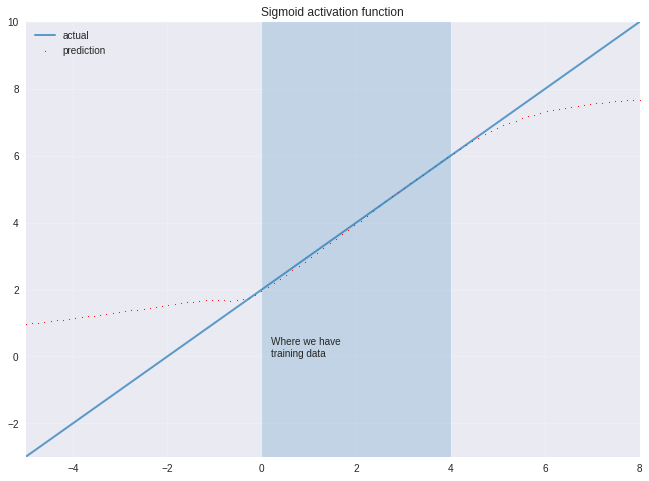

In [76]:
# Visualize your results
fig,ax=plt.subplots(figsize=(11,8))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

x,y=np.linspace(-5,8,100),[]

for xx in x:
    yy=model(torch.tensor([xx,2])).data.cpu().numpy()[0]
    y.append(yy)
y=np.array(y)

fig,ax=plt.subplots(figsize=(11,8))
ax.plot([-5,8],[-3,10],lw=2.0,label='actual',alpha=0.7)
ax.fill_betweenx([-3,10],0,4,alpha=0.2)
ax.scatter(x,y,marker='.',s=3.,label='prediction',color='r')
ax.text(0.2,0,'Where we have \ntraining data')
ax.legend()
ax.set_ylim(-3,10);ax.set_xlim(-5,8);
ax.grid(alpha=0.2);
ax.set_title('Sigmoid activation function');

## Teaching a machine to draw circles

Here the NN learns attempts to learn the 2d rotation matrix, parameterized by the generator of rotations in two dimensions:

$R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$

In [0]:
# First some helper functions for plotting and model training
def train_models(models, optimizers, num_samples=1000, circle_interval=1.0, save_models=False, cuda=False, recurrent=False):
    total_loss = []
    for num in range(num_samples):
        # progress indicator 
        if num % (num_samples//20) ==0:
            print('{0}: %: {1:.3f}'.format(num, num/num_samples * 100))
            
        # data calc 
        # take a random point on the circle of radius 1
        x, theta = torch.ones(2), circle_interval*2*np.pi*torch.rand(1)
        R = torch.zeros(2,2)
        R[0,:] = torch.Tensor([np.cos(theta[0]),-np.sin(theta[0])])
        R[1,:] = torch.Tensor([np.sin(theta[0]), np.cos(theta[0])])
        
        data, target = Variable(theta), Variable(torch.mv(R,x))
        
        # Check if GPU can be used
        if cuda:
            data, target = data.cuda(), target.cuda()
            
        # learning phases 
        for idx, model in enumerate(models):
            loss_iter = []
            # forward 
            if recurrent:
                output = model(data,None)
            else:
                output = model(data)
            loss = criterion(output, target)
            loss_iter.append(loss.data.item())
            # backward 
            optimizers[idx].zero_grad()
            loss.backward()
            optimizers[idx].step()
        total_loss.append(np.mean(loss_iter))
        
    # save model state 
    if save_models:
        for l,model in enumerate(models):
            torch.save(model.state_dict(), 'rotations_{}.pth'.format(l))
    return total_loss,theta
        
def plot_circles(models, offset=0, CI=False, cuda=False, recurrent=False):
    fig, axes = plt.subplots(figsize=(5*3,3.9),ncols=3)
    x = torch.ones(2)
    for k,ax in enumerate(axes):
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='r')
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='b')
        x_real, y_real = [],[]
        x_mean, y_mean = [],[]
        x_std, y_std = [],[]
        for theta in np.linspace((k+offset) *2*np.pi,(k+1+offset) *2*np.pi,300):
            x_model,y_model = [],[]
            # sythetic (real) data 
            data = Variable(torch.Tensor([theta]))#.cuda()
            R = torch.zeros(2,2)
            R[0,:] = torch.Tensor([np.cos(theta),-np.sin(theta)])
            R[1,:] = torch.Tensor([np.sin(theta), np.cos(theta)])
            real = torch.mv(R,x)
            if cuda:
                x_real.append(real[0].cpu().numpy())
                y_real.append(real[1].cpu().numpy())
            else:
                x_real.append(real[0].numpy())
                y_real.append(real[1].numpy())
            # predict w/ all models 
            for model in models:
                if recurrent:
                    outputs=model(data,None).data
                else:
                    outputs=model(data).data
                    
                xx_model, yy_model = outputs[0],outputs[1]
                
                if cuda:
                    x_model.append(xx_model.cpu().numpy())
                    y_model.append(yy_model.cpu().numpy())
                else:
                    x_model.append(xx_model.numpy())
                    y_model.append(yy_model.numpy())
            # summarize all model predictions 
            x_mean.append(np.mean(x_model))
            y_mean.append(np.mean(y_model))
            x_std.append(np.std(x_model))
            y_std.append(np.std(y_model))
        # plotting data 
        ax.scatter(x_real,y_real, facecolors='none', edgecolors='r',label='real data',s=2.)
        ax.scatter(x_mean,y_mean, facecolors='none', edgecolors='k',label='model data', alpha=0.9,s=2.)
        if CI:
            ax.fill_betweenx(y_mean,x_mean-3*np.array(x_std),x_mean+3*np.array(x_std), alpha=0.1,color='b')
            ax.fill_between(x_mean,y_mean-3*np.array(y_std),y_mean+3*np.array(y_std), alpha=0.1,color='b')
        ax.legend()
        ax.set_ylim(-2,2);ax.set_xlim(-2,2);ax.grid(alpha=0.3)
        ax.set_title(r'${}\pi \leq \theta \leq {}\pi$'.format(2*(k+offset),2*(k+1+offset)),y=1.01);
    
    return x_mean, y_mean, np.array(x_std), np.array(y_std)
        
def weight_init(m): # so-called xavier normalization https://arxiv.org/abs/1211.5063
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0]
        fan_in = size[1]
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)

### Defining a neural net as a class

In general, when building your own neural nets, it is likely that you will be defining them in a class.
This gives you the benefit of controlling every aspect of what you want the NN to do, albeit at the cost of 
writing more code

Rotations(
  (layer1): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)
0: %: 0.000
10000: %: 5.000
20000: %: 10.000
30000: %: 15.000
40000: %: 20.000
50000: %: 25.000
60000: %: 30.000
70000: %: 35.000
80000: %: 40.000
90000: %: 45.000
100000: %: 50.000
110000: %: 55.000
120000: %: 60.000
130000: %: 65.000
140000: %: 70.000
150000: %: 75.000
160000: %: 80.000
170000: %: 85.000
180000: %: 90.000
190000: %: 95.000


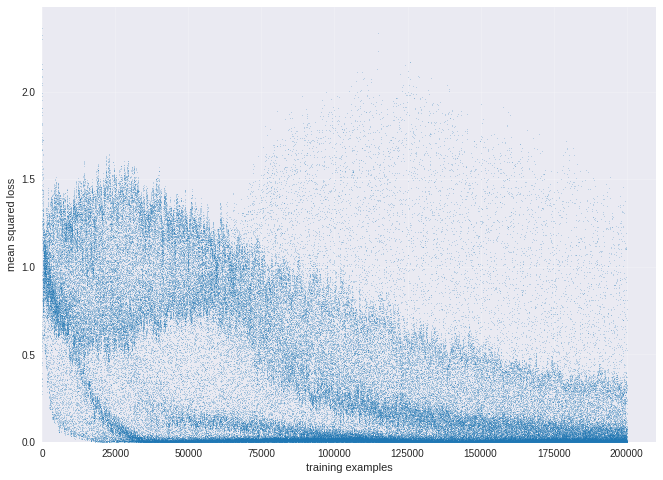

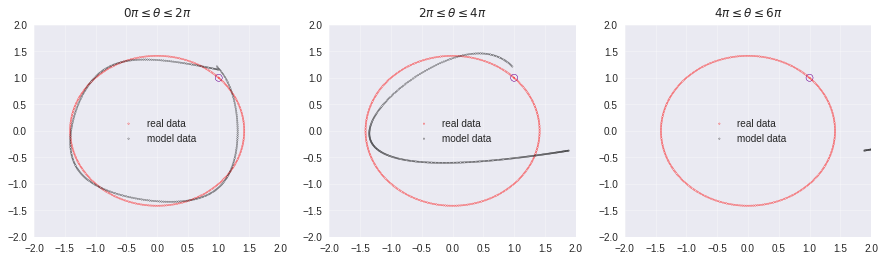

In [78]:
num_nodes=10

# define a class that inputs a nn.Module
class Rotations(nn.Module):
    def __init__(self):
        
        # it must inherit the .__init__() from the super class
        super(Rotations, self).__init__()
        
        # define your layers
        self.layer1 = nn.Sequential(
            nn.Linear(1,num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes,2))
    
    # define forward propagation
    # backpropagation is done for us by pytorch!
    def forward(self, x):
        out=self.layer1(x)
        return out
    
    

model = Rotations()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
print(model)

total_loss, theta = train_models([model], [optimizer], num_samples=200000, circle_interval=2.0)

fig,ax = plt.subplots(figsize=(11,8))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles([model],offset=0,CI=False,recurrent=False)

### Will a deeper network perform better?

In [0]:
# Add more layers to the model and see if performance on the test set increases

num_nodes=10

class Rotations(nn.Module):
    # add more layers and use any combination 
    # of activation functions you deem fit. 
    # See prior example for guidance

model=Rotations()
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.MSELoss()
print(model)

total_loss,theta=train_models([model],[optimizer],num_samples=200000,circle_interval=2.0)

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(total_loss,marker='.',ls='',markersize=.8)
ax.set_ylim(0,);ax.set_xlim(0,);ax.grid(alpha=0.2);
ax.set_xlabel('training examples');ax.set_ylabel('mean squared loss');

output=plot_circles([model],offset=0,CI=False,recurrent=False)

## Bayesian approach

One simple approach to apply the bayesian method described by Yarin Gal, is to take multiple of the same models and train them independently. This allows each model to take independent paths through parameter space, usually finding their way near some optimal minima. In practice, this allows you to hedge the risk of getting stuck in some local minima and missing out on the global one, if it exists. 

A visual way of understanding the situation of training a machine learning model, in general, is by considering a 3D surface plot where the x and y dimensions are two parameters you may modify, with the loss on the z axis, or height, which your aim is to minimize. 

![landscape of deep learning models](http://7xihzu.com1.z0.glb.clouddn.com/20160716/graphical-idea-backprop.png)

The surface that the data carves out in this space is predicated by the data; the aim of the model design is then to build a model flexible and robust enough to find the global minima, but not overly complex enough to overfit and get stuck at a local minima. Also, if your model is too simple, it can skip right over all the minima altogether, and not learn the nuance of the process described by the data. Having too high/low of a learning rate can also make the training process difficult.

# Image Recognition Using Transfer Learning

![Convolutional Architecture](https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png)

In [79]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

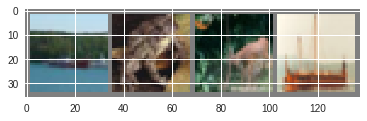

In [81]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [82]:
# what are the labels?
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 ship  frog  deer  ship


In [0]:
# Build our first image recognition NN

class NotQuiteImageNet(nn.Module):
    def __init__(self):
        super(NotQuiteImageNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
imagenet = NotQuiteImageNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(imagenet.parameters(), lr=0.001, momentum=0.9)

In [93]:
# running for short epochs to minimize compute time
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = imagenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.218
[1,  4000] loss: 1.219
[1,  6000] loss: 1.222
[1,  8000] loss: 1.216
[1, 10000] loss: 1.201
[1, 12000] loss: 1.206
[2,  2000] loss: 1.101
[2,  4000] loss: 1.125
[2,  6000] loss: 1.131
[2,  8000] loss: 1.119
[2, 10000] loss: 1.115
[2, 12000] loss: 1.091
Finished Training


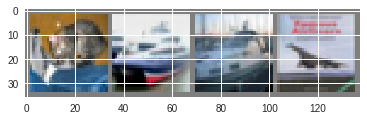

In [94]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [95]:
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:   cat  ship  ship plane


In [0]:
outputs = imagenet(images)

In [97]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship plane


In [98]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = imagenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 57 %


## Transfer Learning

For most computer vision tasks you will encounter, it is almost always true that one or both of these things will be true:

1) You do not have enough data to build your own deep learning model from scratch
2) You will not have enough compute resources (unless you work for a large tech company)

So, instead - and with equally good results - we download a pre-trained model like ResNet50 and remove the last fully connected layer. This allows us to leverage all of the work done by the pre-trained model and modify the last layer to suit our needs.

Let's see this in action

In [0]:

# this normalizes our images for all 3 channels (RGB)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'validation':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', data_transforms['train']),
    'validation':
        datasets.ImageFolder('data/validation', data_transforms['validation'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=32,
            shuffle=True,
            num_workers=0),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=32,
            shuffle=False,
            num_workers=0)}

In [100]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu' 
model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False
 
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 77325528.41it/s]


In [101]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
 
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
 
            print(f'{phase} loss: {epoch_loss}, acc: {epoch_acc}')
    return model
 
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd8c06be710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 397, in __del__
    def __del__(self):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 227, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 878) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.


KeyboardInterrupt: ignored

### Saving Models

In [0]:
torch.save(model_trained.state_dict(),'data/avp_weights.h5')

### Loading Models

In [0]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('data/avp_weights.h5'))

### Make predictions on test images

In [0]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]


In [0]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])
 
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [0]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)


# CNN from Scratch

###  `Datasets` and `Dataloader`s

In PyTorch, you'll usually create or import a `Dataset` subclass to represent your data. Once you've done that, you can use it to instantiate a `Dataloader` object which allows you to easily iterate over your training set in `BATCH_SIZE` chunks.

In [0]:
image_size = 28
num_classes = 10
num_channels = 1
batch_size = 64
id_to_label = {
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot'}


class FashionDataset(Dataset):

    def __init__(self, path, 
                 image_size, num_channels, image_transform=None):
        self.num_channels = num_channels
        self.image_size = image_size
        self.image_transform = image_transform
        data_df = pd.read_csv(path)
        self.X = data_df.values[:, 1:]
        self.X = self.X.reshape(-1, image_size, image_size, num_channels)
        self.X = self.X.astype('float32')
        self.y = data_df.values[:, 0]
        
    def __getitem__(self, index):
        batch_X, batch_y = self.X[index], self.y[index]
        if self.image_transform is not None:
            batch_X = self.image_transform(batch_X)
        return batch_X, batch_y

    def __len__(self):
        return len(self.X)

# This simple transform coverts the image from an numpy array
# to a PyTorch tensor and remaps its values from 0-255 to 0-1. 
# Many other types of transformations are available, and they 
# can easily be composed into a pipeline. For more info see: 
# https://pytorch.org/docs/stable/torchvision/transforms.html
image_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionDataset(
    'fashionmnist/fashion-mnist_train.csv', 
    image_size, 
    num_channels, 
    image_transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_dataset = FashionDataset(
    'fashionmnist/fashion-mnist_test.csv', 
    image_size, 
    num_channels, 
    image_transform)

val_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size)

### Show some examples from the training set

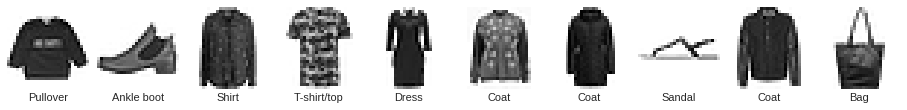

In [104]:
def plot_images(data, labels, image_size):
    size = 28
    fig, axes = plt.subplots(
        1, data.shape[0], figsize=(16, 4), 
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(image_size, image_size), cmap='binary')
        ax.set_xlabel(labels[i])
        
images = train_dataset.X[:10]
class_ids = train_dataset.y[:10]
class_labels = [id_to_label[class_id] for class_id in class_ids]
plot_images(images, class_labels, image_size)

## Modeling

The model below uses a single convolution with only 4 filters. Because of the simplicity of our dataset, it still manages to achieve nearly 90% accuracy after only 5 epochs and a minute or two of training.

Complete `FashionModel` by writing the `forward()` function. The layers you need have already been created for you; you just need to pass the input through them and return it. (Hint: You'll need to reshape the output from the convolutional layer.) Once you've got the model up and running, try to see if you can increase the accuracy on the validation set to above 95%.

Things you might try:

* Increasing the number of filters per convolution.
* Adding more convolutions.
* Adding a `BatchNorm2d` layer after `Conv2d`.
* Increasing the number of epochs.
* Changing the kernel size.
* Using different types of pooling or using stride > 1 in convolutional layers instead of pooling.

You might also find the [PyTorch API reference](https://pytorch.org/docs/stable/nn.html) useful.

In [0]:
class FashionModel(nn.Module):
    
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.linear = nn.Linear(14 * 14 * 4, num_classes)
        
        ## Add more layers
        
    def forward(self, x):
        ## Don't forgot to add the forward method!
        return x

# Instantiate the model.    
model = FashionModel(num_channels, num_classes)

# Send the model's tensors to the GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)      

## Training

In [106]:
num_epochs = 10
log_freq = 100
checkpoint_path = 'checkpoint.pickle'


optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
for epoch in range(1, num_epochs + 1):
    model.train()  # Switch to training mode.
    print(f'Starting epoch {epoch}.')
    epoch_start_time = time.time()
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_id, (batch_X, batch_y) in enumerate(train_dataloader):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Periodically print the loss and prediction accuracy.
        running_loss += loss.item()
        y_pred = output.argmax(dim=-1)
        running_accuracy += accuracy_score(batch_y, y_pred)
        if batch_id % log_freq == log_freq - 1:
            average_loss = running_loss / log_freq
            average_accuracy = running_accuracy / log_freq
            print(f'Mini-batch: {batch_id + 1}/{len(train_dataloader)} '
                  f'Loss: {average_loss:.5f} Accuracy: {average_accuracy:.5f}')
            running_loss = 0.0
            running_accuracy = 0.0
            
    # Log elapsed_time for the epoch.            
    elapsed_time = time.time() - epoch_start_time
    print(f'\nEpoch {epoch} completed in {elapsed_time // 60:.0f} minutes '
          f'{elapsed_time % 60:.0f} seconds.')
    
    # Calculate and log loss on validation set.
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        for batch_id, (batch_X, batch_y) in enumerate(val_dataloader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            running_loss += loss.item()
            y_pred = output.argmax(dim=-1)  
            running_accuracy += accuracy_score(batch_y, y_pred)
        average_loss = running_loss / len(val_dataloader)
        average_accuracy = running_accuracy / len(val_dataloader)
        print(f'Val Loss: {average_loss:.5f} Val Accuracy: {average_accuracy:.5f}\n')

Starting epoch 1.


RuntimeError: ignored

# RNN Character Level Generation

Text generation is a fun way to familiarize yourself with Recurrent Neural Nets.

In this notebook, we will deal with **character-level** text generation and why they can be just as useful as word-level text generation.

For this example, we'll be using text files to generate code similar to our input. In other words, if we put in Trump tweets, our generator should output words that sound like Trump.

### Our current understanding of RNNs
![](https://github.com/robert-alvarez/pytorch_tutorial/blob/master/img/LSTM_next_character.png?raw=1)


### Reminder

![](https://github.com/robert-alvarez/pytorch_tutorial/blob/master/img/rnn_unrolling.png?raw=1)

#### "RNNs have a hidden state that feeds back into the cell at the next time step"

## What is actually going on?

### Example with sequence length 5

![](https://github.com/robert-alvarez/pytorch_tutorial/blob/master/img/rnn_forward.png?raw=1)

### What about the backwards pass?

![](https://github.com/robert-alvarez/pytorch_tutorial/blob/master/img/rnn_backward.png?raw=1)

## Preprocessing

In [0]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

In [0]:
# read in file to train RNN
file = unidecode.unidecode(open('data/shakespeare.txt').read())
file_len = len(file)
print(f'file_len = {file_len}')

To give our model inputs from this large string of text, we'll split it up into chunks

In [0]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

## Build Model

This model will take as input the character for step $t$ and is expected to output the next character for step $t+1$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

## Inputs and Targets

Now that we've defined our model, we need to give it both input data, via our chunks, and our target data. Each character is one-hot encoded to the vocab size 

In [0]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

Now that we can generate chunks of data, we can build our inputs and targets.

Our inputs will be all of the chunk except for the last letter. 

Our target will be all of the chunk except for the first letter.

In [0]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

## Evaluating the Model

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

## Training

In [0]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [0]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [0]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### Load pre-trained models

In [0]:
trump = torch.load('data/potus.pt')
# billy = torch.load('models/shakespeare.pt')

In [0]:
# Evaluate Trump
print(evaluate(trump, 'Mueller Witch Hunt! ', predict_len=140, temperature=0.7))

In [0]:
# Evaluate Billy Shakespeare
print(evaluate(billy, 'To be or not to be: ', predict_len=200, temperature=0.5))

# Resources

[tensor images](https://hackernoon.com/learning-ai-if-you-suck-at-math-p4-tensors-illustrated-with-cats-27f0002c9b32)

[alien vs predator](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)

[unreasonable reffectiveness of neural nets](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[pytorch.org](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

[Richard Galvez](https://richardagalvez.github.io/)
